# Importing Data from BIDS (Brain Imaging Data Structure)

Although there is no universal data storage format for neural data, the BIDS format has seen widespread adoption. This tutorial demonstrates how to easily load data from a BIDS format into a ``Data`` object using the `read_bids` function. Events stored in the BIDS format are naturally segmented to form the "trials" in the ``Data``, facilitating easy data analysis.

**Note** Loading data from BIDS requires the additional dependency [MNE-BIDS](https://mne.tools/mne-bids/stable/index.html), which is not a hard dependency of `naplib-python`, so it must be installed separately. You can find installation instructions for `MNE-BIDS` [here](https://mne.tools/mne-bids/stable/install.html). This tutorial was adapted from a [similar tutorial](https://mne.tools/mne-bids/stable/auto_examples/read_bids_datasets.html#sphx-glr-auto-examples-read-bids-datasets-py) by `MNE-BIDS`.

Also, this tutorial makes use of an [openneuro](https://openneuro.org/) dataset for illustration purposes. The data downloaded here is about 1.5 GB from one subject.

In [1]:
import os
from os import path
import openneuro
from mne.datasets import sample
from mne_bids import print_dir_tree
import numpy as np
import matplotlib.pyplot as plt

from naplib.io import read_bids

In [2]:
dataset = 'ds004229'
subject = '102'
dataset = 'ds002778'
subject = 'pd6'

bids_root = path.join(path.dirname(sample.data_path()), dataset)
print(bids_root)
if not path.isdir(bids_root):
    os.makedirs(bids_root)


/home/gavin/mne_data/ds002778


In [3]:
openneuro.download(dataset=dataset, target_dir=bids_root,
                   include=[f'sub-{subject}'])


👋 Hello! This is openneuro-py 2022.1.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds002778 …
👉 Retrieving up to 19 files (5 concurrent downloads).
✅ Finished downloading ds002778.

🧠 Please enjoy your brains.



Skipping participants.tsv: already downloaded.: 100%|##########| 1.62k/1.62k [00:00<?, ?B/s]

Skipping participants.json: already downloaded.: 100%|##########| 1.24k/1.24k [00:00<?, ?B/s]

Re-downloading README: file size mismatch.: 0.00B [00:00, ?B/s]

Re-downloading sub-pd6_ses-off_task-rest_beh.tsv: file size mismatch.: 0.00B [00:00, ?B/s]

Re-downloading dataset_description.json: file size mismatch.: 0.00B [00:00, ?B/s]

Re-downloading CHANGES: file size mismatch.: 0.00B [00:00, ?B/s]

Re-downloading sub-pd6_ses-off_task-rest_beh.json: file size mismatch.: 0.00B [00:00, ?B/s]

Skipping sub-pd6_ses-on_task-rest_channels.tsv: already downloaded.: 100%|##########| 2.22k/2.22k [00:00<?, ?B…

Skipping sub-pd6_ses-on_task-rest_eeg.json: already downloaded.: 100%|##########| 471/471 [00:00<?, ?B/s]

Skipping sub-pd6_ses-on_scans.tsv: already downloaded.: 100%|##########| 74.0/74.0 [00:00<?, ?B/s]

Re-downloading sub-pd6_ses-on_task-rest_beh.tsv: file size mismatch.: 0.00B [00:00, ?B/s]

Skipping sub-pd6_ses-on_task-rest_events.tsv: already downloaded.: 100%|##########| 51.0/51.0 [00:00<?, ?B/s]

Skipping sub-pd6_ses-off_scans.tsv: already downloaded.: 100%|##########| 75.0/75.0 [00:00<?, ?B/s]

Skipping sub-pd6_ses-off_task-rest_events.tsv: already downloaded.: 100%|##########| 66.0/66.0 [00:00<?, ?B/s]

Skipping sub-pd6_ses-on_task-rest_beh.json: already downloaded.: 100%|##########| 433/433 [00:00<?, ?B/s]

Re-downloading sub-pd6_ses-off_task-rest_channels.tsv: file size mismatch.: 0.00B [00:00, ?B/s]

Skipping sub-pd6_ses-on_task-rest_eeg.bdf: already downloaded.: 100%|##########| 17.4M/17.4M [00:00<?, ?B/s]

Re-downloading sub-pd6_ses-off_task-rest_eeg.json: file size mismatch.: 0.00B [00:00, ?B/s]

Skipping sub-pd6_ses-off_task-rest_eeg.bdf: already downloaded.: 100%|##########| 11.5M/11.5M [00:00<?, ?B/s]

#### The downloaded data has the following BIDS file structure

In [4]:
print_dir_tree(bids_root, max_depth=4)

|ds002778/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.json
|--- participants.tsv
|--- sub-pd6/
|------ eeg/
|------ ses-off/
|--------- sub-pd6_ses-off_scans.tsv
|--------- beh/
|------------ sub-pd6_ses-off_task-rest_beh.json
|------------ sub-pd6_ses-off_task-rest_beh.tsv
|--------- eeg/
|------------ sub-pd6_ses-off_task-rest_channels.tsv
|------------ sub-pd6_ses-off_task-rest_eeg.bdf
|------------ sub-pd6_ses-off_task-rest_eeg.json
|------------ sub-pd6_ses-off_task-rest_events.tsv
|------ ses-on/
|--------- sub-pd6_ses-on_scans.tsv
|--------- beh/
|------------ sub-pd6_ses-on_task-rest_beh.json
|------------ sub-pd6_ses-on_task-rest_beh.tsv
|--------- eeg/
|------------ sub-pd6_ses-on_task-rest_channels.tsv
|------------ sub-pd6_ses-on_task-rest_eeg.bdf
|------------ sub-pd6_ses-on_task-rest_eeg.json
|------------ sub-pd6_ses-on_task-rest_events.tsv
|--------- meg/


### Reading the information into a Data object

In this task, the stimulus recorded is simply a sudden spike in the 'stim' channels, so the associated events have duration=0. For the sake of this tutorial, we will cut the data into trials based on the 'onset' of one event and ending at the onset of the next. If the durations of the stimulus events were meaningful, we could cut by the 'duration' of each event instead. See the `read_bids` documentation for more details.

In [5]:
resp_channels = ['Fp1','AF3','F7','F3','FC1','FC5','T7','C3','CP1','CP5','P7',
                 'P3','Pz','PO3','O1','Oz','O2','PO4','P4','P8','CP6','CP2',
                 'C4','T8','FC6','FC2','F4','F8','AF4','Fp2','Fz','Cz']

In [6]:
data = read_bids(root=bids_root, subject=subject, datatype='eeg', task='rest', suffix='eeg', session='off', resp_channels=resp_channels)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 19.14it/s]


#### Visualize the stims and responses for the first 3 seconds of one of the events

In [7]:
sfreq = int(data[0]['sfreq']) # sampling frequency of the data
sfreq

512

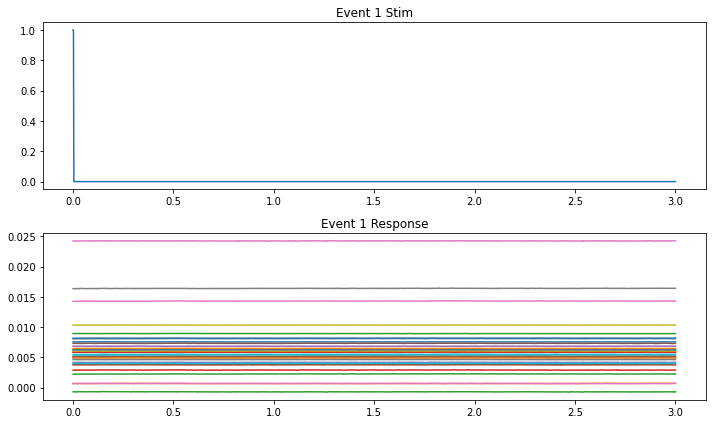

In [8]:
t = np.linspace(0, 3, 3*sfreq)

fig, axes = plt.subplots(2,1, figsize=(10,6))
axes[0].plot(t, data[1]['stim'][:3*sfreq,:])
axes[0].set_title('Event 1 Stim')

axes[1].plot(t, data[1]['resp'][:3*sfreq,:])
axes[1].set_title('Event 1 Response')
axes[1].set_label('Time (s)')
plt.tight_layout()
plt.show()


### Storing a small portion of data before the onset of the stimulus event

We can use the `befaft` parameter to store an additional bit of the recording before and/or after each stimulus event region.

In [9]:
befaft = [1,0] # keep 1 second before the stimulus, nothing extra after

data2 = read_bids(root=bids_root, subject=subject, datatype='eeg', task='rest', suffix='eeg', session='off', befaft=befaft, resp_channels=resp_channels)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 21.07it/s]


#### Now, when we visualize we have a bit of data from before the stimulus onset

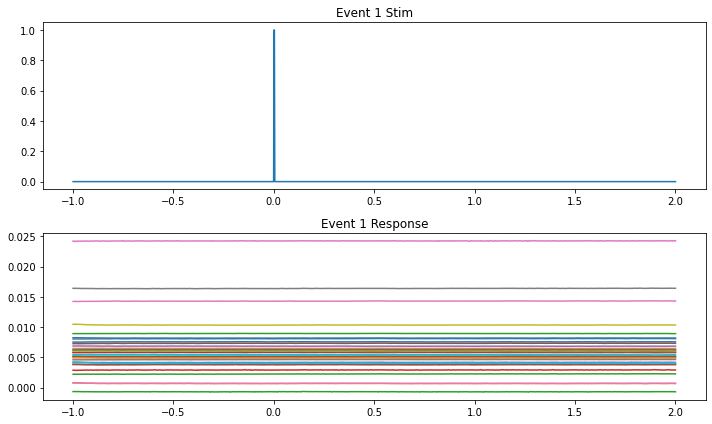

In [10]:
t = np.linspace(-1, 2, 3*sfreq)

fig, axes = plt.subplots(2,1, figsize=(10,6))
axes[0].plot(t, data2[1]['stim'][:3*sfreq,:])
axes[0].set_title('Event 1 Stim')

axes[1].plot(t, data2[1]['resp'][:3*sfreq,:])
axes[1].set_title('Event 1 Response')
axes[1].set_label('Time (s)')
plt.tight_layout()
plt.show()

#### All the metadata has been stored in the mne_info attribute of the Data

In [11]:
data.mne_info

<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, ...
 chs: 32 EEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 104.0 Hz
 meas_date: 2011-02-18 13:07:18 UTC
 nchan: 32
 projs: []
 sfreq: 512.0 Hz
 subject_info: 9 items (dict)
>